# Team MMA analysis for CompanyX


Add user folder to the list of paths containing libraries and load some initial libraries.

In [1]:
#dir.create('UserLibrary')
.libPaths( c( .libPaths(), 'UserLibrary') )

In [2]:
library(plyr)
library(dplyr)
library(lubridate)
library(tidyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following object is masked from ‘package:plyr’:

    here

The following object is masked from ‘package:base’:

    date



## Dataset

The dataset you will work with is a typical dataset that a retailer would have access to.

**NOTE: This dataset is confidential and private and is not to leave CompanyX's servers.**

## Accessing the data

In [3]:
customers <- read.csv('/home/companyx/work/public/data/customers.csv')

In [4]:
products <- read.csv('/home/companyx/work/public/data/products.csv')

In [5]:
transactions <- read.csv('/home/companyx/work/public/data/transactions.csv') %>% 
    mutate(transaction_date=parse_date_time(transaction_date, orders='ymd HMS'))

## Exploratory analysis

Descriptive stats to enable us to ask the right questions

In [6]:
customers$registration_date = as.Date(customers$registration_date, format="%Y-%m-%d")

User registration date range

In [7]:
print(paste("Start at", min(customers$registration_date), "until", max(customers$registration_date)))

[1] "Start at 2007-07-20 until 2010-12-31"


Сheck how many distinct values we have in each categorization level

In [8]:
print(paste("Brands:", n_distinct(products$brand_id)))
print(paste("Divisions:", n_distinct(products$division)))
print(paste("Categories:", n_distinct(products$category)))
print(paste("Subcategories:", n_distinct(products$subcategory)))
print(paste("Finelines:", n_distinct(products$fineline)))

[1] "Brands: 764"
[1] "Divisions: 26"
[1] "Categories: 26"
[1] "Subcategories: 108"
[1] "Finelines: 27760"


Get numbers of products in each subcategory

In [9]:
print(paste("Unique transactions:", n_distinct(transactions$sale_id)))

[1] "Unique transactions: 6255655"


Join customer and product information to transactions table

In [10]:
full_txns = transactions %>%
    left_join(products, by='product_id') %>%
    left_join(customers, by='customer_id')

Get day of week for each transaction

In [11]:
full_txns$weekday = as.factor(weekdays(as.Date(full_txns$transaction_date)))

Get a distribution of transactions by weekdays

In [12]:
weekday_dist = full_txns %>%
    group_by(weekday) %>%
    summarize(n=n_distinct(sale_id), pct_total=(n/6255655)*100)

In [13]:
weekday_dist

weekday,n,pct_total
Monday,3047492,48.71579
Sunday,3208163,51.28421


Graph the weekly distribution

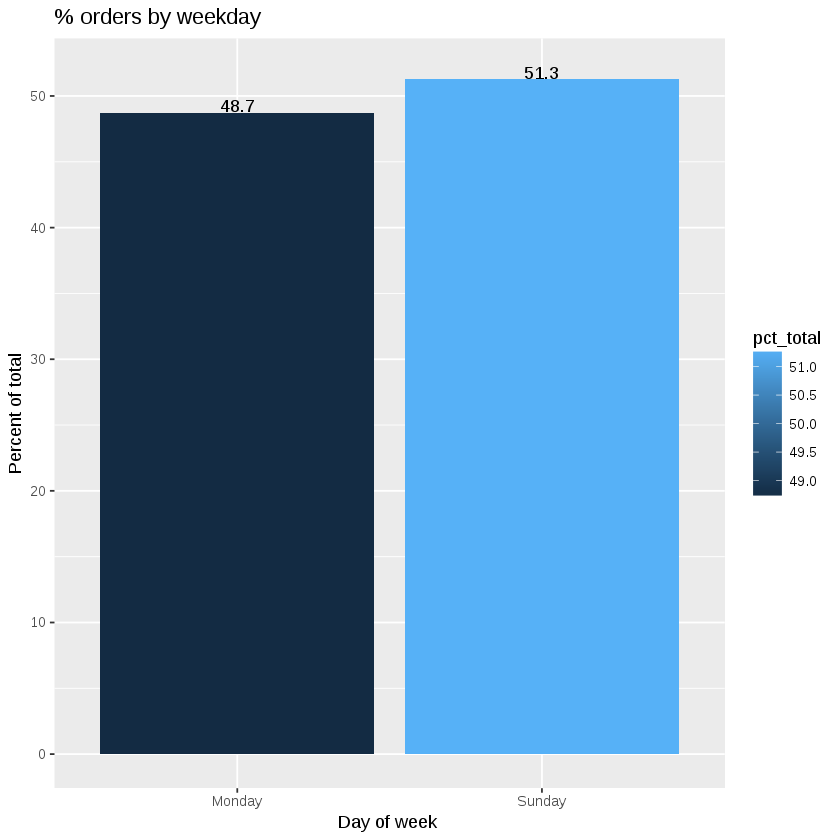

In [32]:
library(ggplot2)
options(scipen=10000) # fixes the sce
ggplot(weekday_dist, aes(x = weekday, y=pct_total, fill=pct_total, label = paste0(round(pct_total, 1)))) +
    geom_bar(stat = "identity") +
    labs(title = "% orders by weekday", y = "Percent of total", x = "Day of week ") +
    geom_text(nudge_y = .5)

Get month for each transaction and its number equivalent

In [15]:
full_txns$month = months(as.Date(full_txns$transaction_date))
full_txns$nmonth = month(as.Date(full_txns$transaction_date))

Get a distribution of transactions by month

In [16]:
month_dist = full_txns %>%
    group_by(month) %>%
    summarise(n = n(), nmonth = mean(nmonth)) %>%
    mutate(pct_total = (n*100/nrow(full_txns))) %>%
    arrange(nmonth)

month_dist$month <- factor(month_dist$month, levels = month_dist$month[order(month_dist$nmonth)])

Graph the monthly distribution

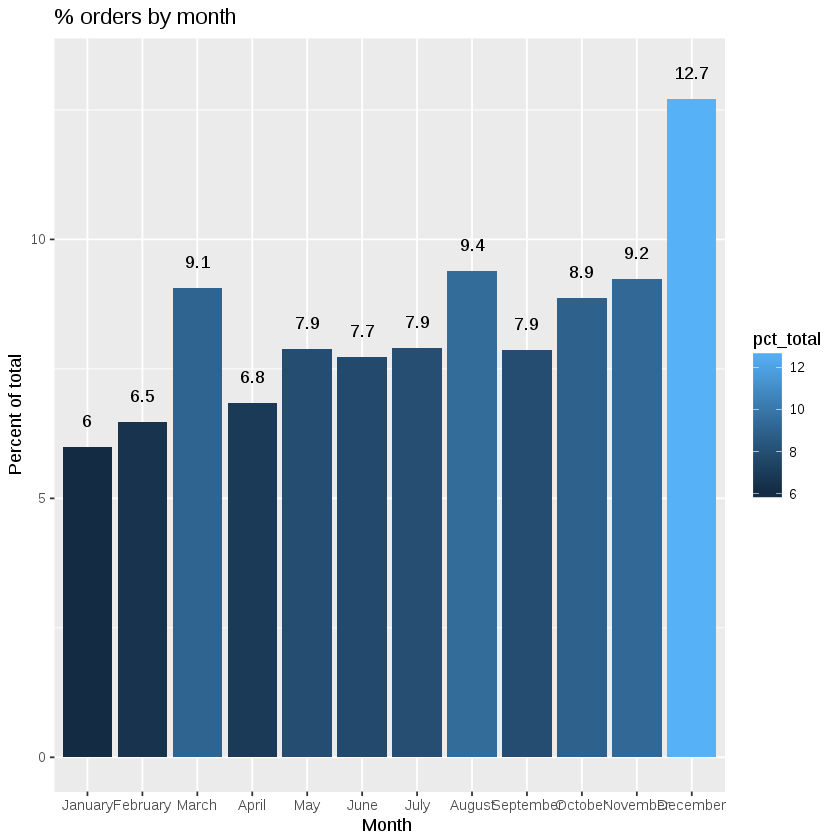

In [25]:
ggplot(month_dist, aes(x = month, y = pct_total, fill = pct_total, label = paste0(round(pct_total, 1)))) +
    geom_bar(stat = "identity") +
    labs(title = "% orders by month", y = "Percent of total", x = "Month ") +
    geom_text(nudge_y = .5)

Get average basket size and plot it

In [ ]:
avg_baskets = full_txns %>% 
  group_by(sale_id) %>% 
  summarize(nprods = n())

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

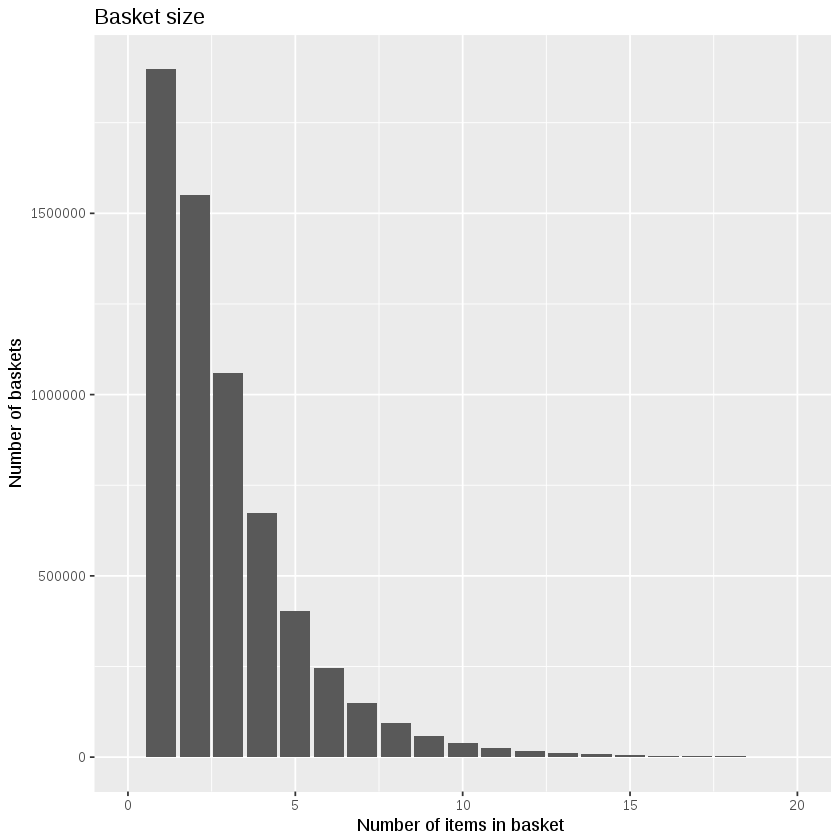

In [30]:
ggplot(avg_baskets, aes(x = nprods)) +
  geom_histogram(stat = "count", bins = 20) + 
  labs(title = "Basket size", y = "Number of baskets", x = "Number of items in basket ") +
  coord_cartesian(xlim=c(0,20))

Most valuable customers (by number of transactions) + plot

In [31]:
txns_mvp = full_txns %>%
    group_by(customer_id) %>%
    summarize(n = n_distinct(sale_id))

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

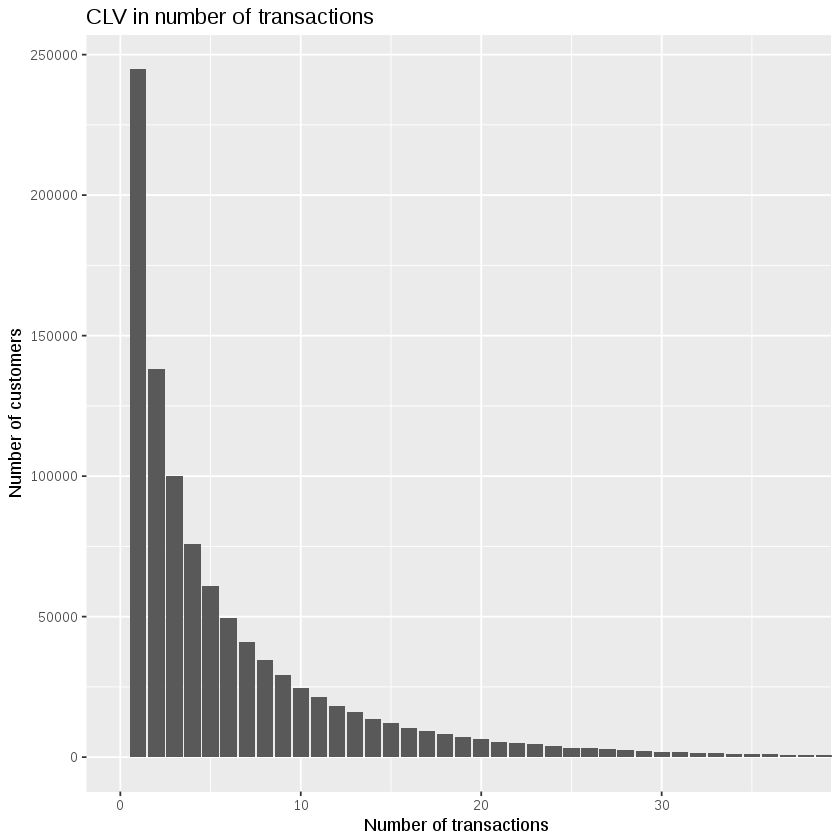

In [35]:
ggplot(txns_mvp, aes(x = n)) +
    geom_histogram(stat = 'count', bins = 10) + 
    labs(title = "CLV in number of transactions", y = "Number of customers", x = "Number of transactions ") +
    coord_cartesian(xlim=c(0,37.5))

Most valuable customers by total spending + plot

In [36]:
spend_mvp = full_txns %>%
    group_by(customer_id) %>%
    summarize(total = sum(product_price))

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

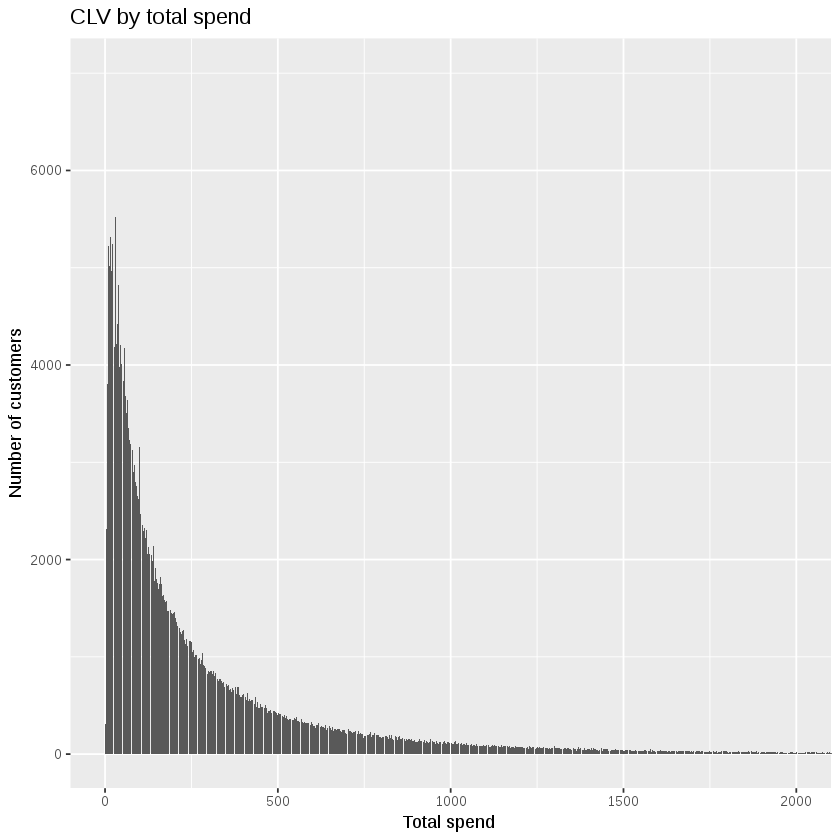

In [41]:
ggplot(spend_mvp, aes(x = total)) +
    geom_histogram(stat = 'count', bins = 10) + 
    labs(title = "CLV by total spend", y = "Number of customers", x = "Total spend ") +
    coord_cartesian(xlim=c(0,2000))

Distribution of transactions by total price + plot

In [ ]:
total_baskets = full_txns %>% 
    group_by(sale_id) %>%
    summarize(total = sum(product_price))

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

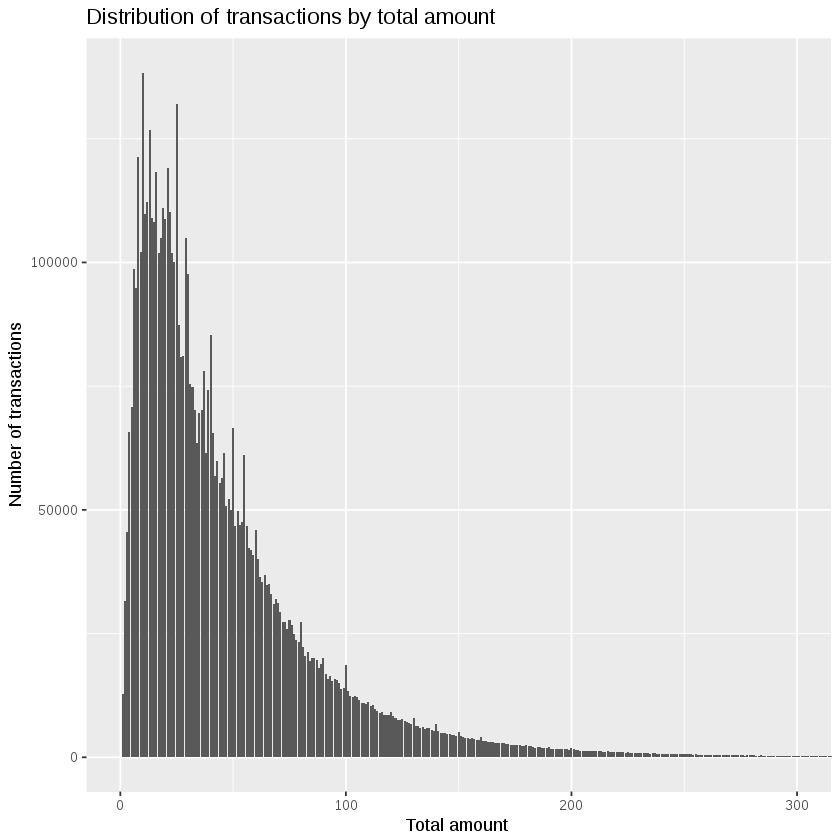

In [44]:
ggplot(total_baskets, aes(x = total)) +
  geom_histogram(stat = "count", bins = 30) + 
  labs(title = "Distribution of transactions by total amount", y = "Number of transactions", x = "Total amount ") +
  coord_cartesian(xlim=c(0, 300))

Most purchased brands

In [45]:
brands = full_txns %>%
    group_by(brand_id) %>%
    summarize(n = n_distinct(sale_id))

Most purchased division, category, subcategory

Distribution of customer registrations per month + plot.
Seems like a post-recession dip in the middle.

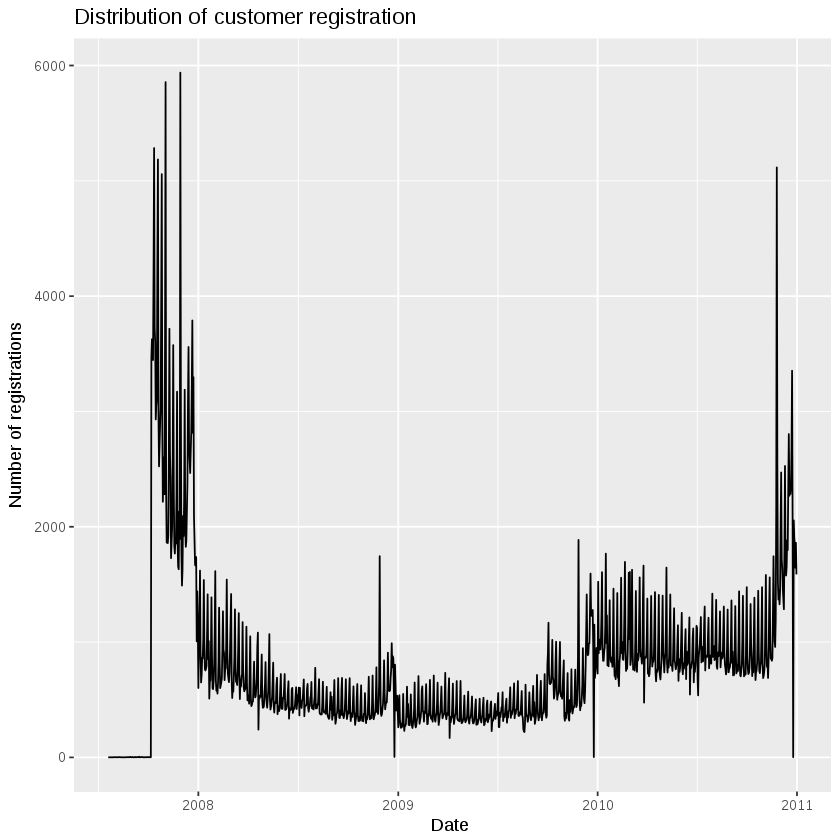

In [47]:
customers_ts = customers %>%
    group_by(registration_date) %>%
    summarize(n = n())

ggplot(customers_ts, aes(x = registration_date, y = n)) +
  labs(title = "Distribution of customer registration", y = "Number of registrations", x = "Date ") +
  geom_path()

Product price distribution plot

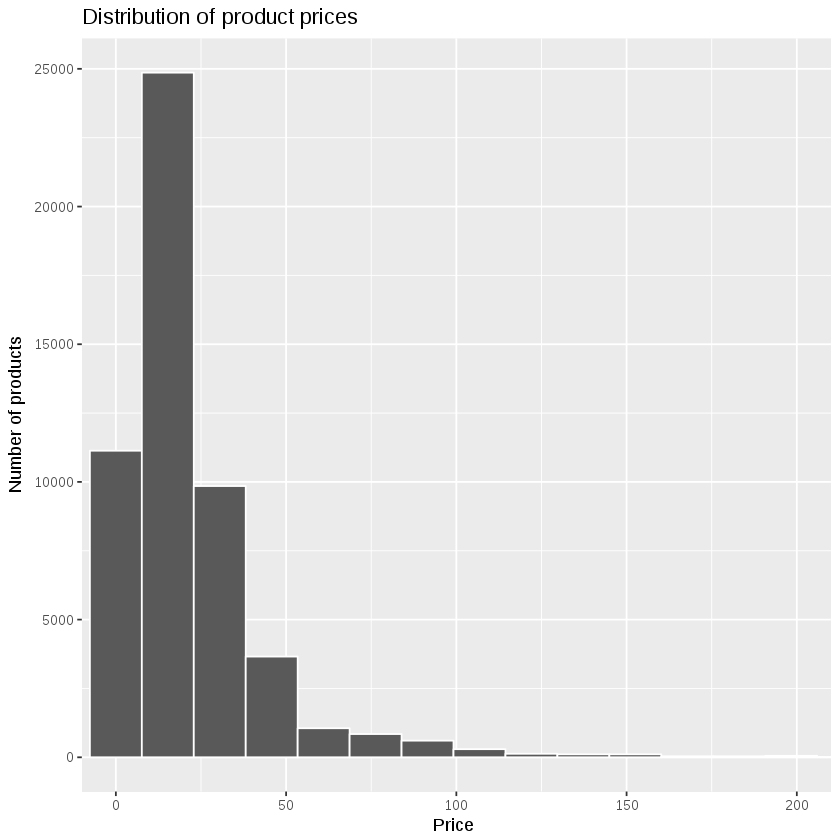

In [52]:
ggplot(products, aes(x = price)) +
  geom_histogram(bins = 40, colour='white') +
  labs(title = "Distribution of product prices", y = "Number of products", x = "Price ") +
  coord_cartesian(xlim=c(0, 200))

Distribution of transactions by date + plot

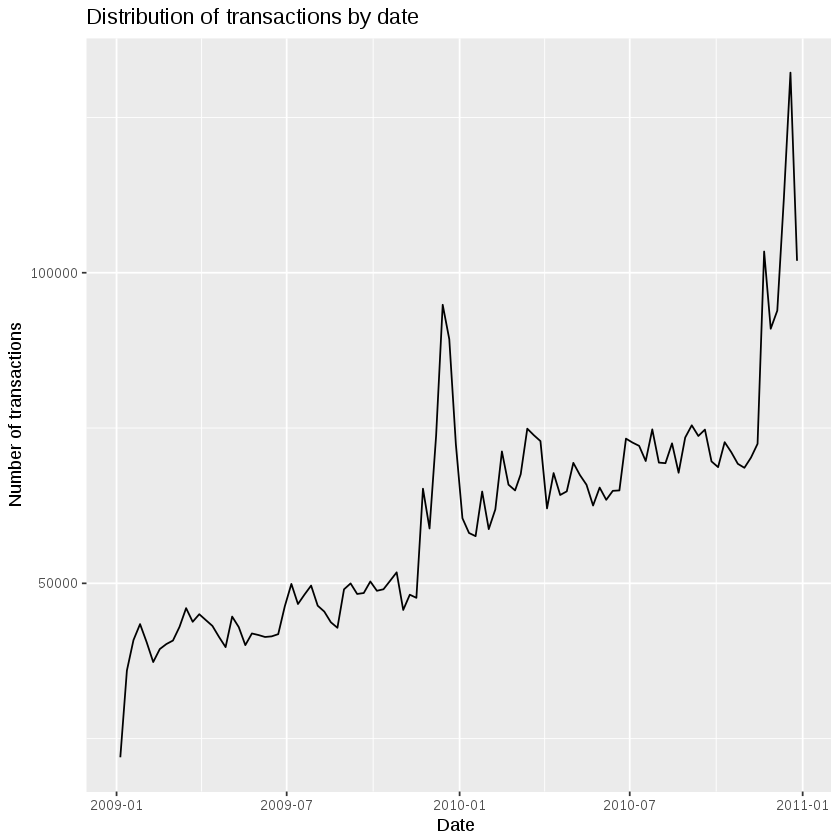

In [53]:
txns_ts = full_txns %>%
    group_by(transaction_date) %>%
    summarize(n = n_distinct(sale_id))

ggplot(txns_ts, aes(x = transaction_date, y = n)) +
  labs(title = "Distribution of transactions by date", y = "Number of transactions", x = "Date ") +
  geom_path()

Distribution of revenue by date + plot

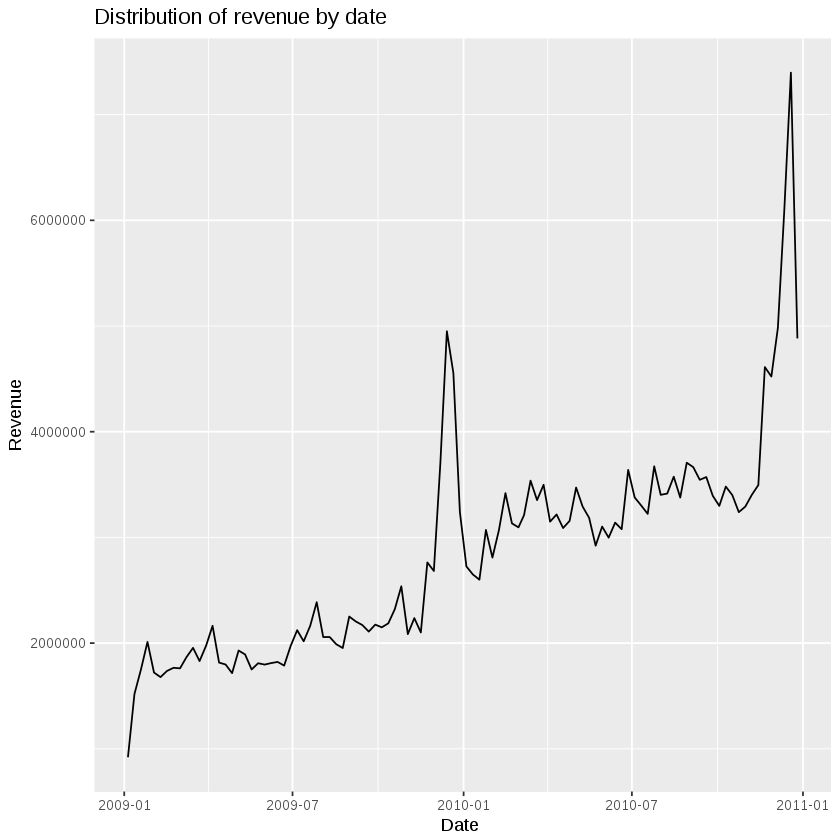

In [54]:
revenue_ts = full_txns %>%
    group_by(transaction_date) %>%
    summarize(rev = sum(product_price))

ggplot(revenue_ts, aes(x = transaction_date, y = rev)) +
  labs(title = "Distribution of revenue by date", y = "Revenue", x = "Date ") +
  geom_path()

Get baskets for analysis

In [ ]:
baskets = transactions %>%
    group_by(sale_id) %>%
    mutate(total.qty = sum(product_quantity), total.price = sum(product_price)) %>%
    select(sale_id, total.qty, total.price, customer_id, transaction_date)

baskets = unique(baskets)

### Market basket analysis

Get a top spending customer

In [80]:
spend_mvp %>%
    arrange(desc(total)) %>%
    head()

customer_id,total
50109082,61044
48436768,34344
53894508,24322
54108402,21852
49752635,20264
33693411,19278


Get the customer's transactions for Customer with ID 50109082

In [81]:
cust_trans = transactions %>%
    filter(customer_id == 50109082) %>%
    select(sale_id, product_id)

Prepare the data for manual arules

In [82]:
library(reshape2)

intr <- ddply(cust_trans, .(sale_id,product_id), summarize, n=length(1))


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



In [ ]:
head(intr)

Create a transaction-product matrix

In [84]:
prod_mtx = as.matrix(dcast(intr, sale_id ~ product_id, value.var="n", fill=0))

Check how many transactions this user has

In [85]:
n_distinct(prod_mtx[,1])

[1] 256

Prepare variables and an empty dataframe for running association analysis

In [86]:
columns = colnames(prod_mtx)
sale_id.qty = n_distinct(intr$sale_id)
ncols = ncol(prod_mtx)
dfm = data.frame(
    prod1=character(),
    prod2=character(),
    freq=integer(),
    prod1_c=integer(),
    prod2_c=integer()
)

Doing 1-to-1 associations manually, since arules is not working.
Very slow, but works for the purposes of the presentation.
Of course, using 'arules' is preferred and is usually very fast.

In [87]:
for (i in 2:ncols) {
    for (j in 2:ncols) {
        if (i != j) {
            prod_i = as.integer(prod_mtx[, i])
            prod_j = as.integer(prod_mtx[, j])
            prod1_count = sum(prod_i)
            prod2_count = sum(prod_j)
            # multiply product pair vectors
            product_vector = prod_i * prod_j
            # check the number of pair occurrences in baskets
            count_matches = sum(product_vector)
            if (count_matches > 0) {
                # save values to new matrix
                dfm = rbind(dfm, data.frame(
                    prod1=columns[i],
                    prod2=columns[j],
                    freq=count_matches,
                    prod1_c=prod1_count,
                    prod2_c=prod2_count
                ))
            }
        }
    }
}

Get top pairs for the customer

In [90]:
dfm %>%
    group_by(prod1, prod2) %>%
    arrange(desc(freq)) %>%
    head()

prod1,prod2,freq,prod1_c,prod2_c
4772,4938,10,11,10
4938,4772,10,10,11
25879,26054,10,10,11
26054,25879,10,11,10
23992,24635,9,14,10
24635,23992,9,10,14


Calculate interest measures to get the probability of purchase to calculate monetary gain from recommendations

In [91]:
dfm1 = dfm %>%
    mutate(
        support_lhs = prod1_c/sale_id.qty,
        support_rhs=prod2_count/sale_id.qty,
        support=freq/sale_id.qty,
        confidence=support/support_lhs,
        lift=support/(support_lhs*support_rhs)
    )                    

Interest measure 'confidence' can be used as a propensity to buy product 2, given that product 1 is in the basket

In [92]:
dfm1 %>%
    group_by(prod1) %>%
    arrange(desc(freq)) %>%
    head(20)

prod1,prod2,freq,prod1_c,prod2_c,support_lhs,support_rhs,support,confidence,lift
4772,4938,10,11,10,0.04296875,0.01171875,0.03906250,0.9090909,77.57576
4938,4772,10,10,11,0.03906250,0.01171875,0.03906250,1.0000000,85.33333
25879,26054,10,10,11,0.03906250,0.01171875,0.03906250,1.0000000,85.33333
26054,25879,10,11,10,0.04296875,0.01171875,0.03906250,0.9090909,77.57576
23992,24635,9,14,10,0.05468750,0.01171875,0.03515625,0.6428571,54.85714
24635,23992,9,10,14,0.03906250,0.01171875,0.03515625,0.9000000,76.80000
1089,28637,8,9,19,0.03515625,0.01171875,0.03125000,0.8888889,75.85185
3228,6169,8,8,9,0.03125000,0.01171875,0.03125000,1.0000000,85.33333
6169,3228,8,9,8,0.03515625,0.01171875,0.03125000,0.8888889,75.85185
12422,12674,8,8,9,0.03125000,0.01171875,0.03125000,1.0000000,85.33333


Let's output the two top products, to see their prices

### Classification (spend/attrition modelling)

Prepare the data to run predictive models

In [55]:
print(paste("Start at", min(transactions$transaction_date), "until", max(transactions$transaction_date)))

[1] "Start at 2009-01-05 until 2010-12-26"


Train period will be [2009-01, 2009-12]

In [56]:
train_txns <- transactions %>% filter(transaction_date >= '2009-01-01' & transaction_date < '2010-01-01')
test_txns <- transactions %>% filter(transaction_date >= '2010-01-01' & transaction_date < '2010-02-01')

In [57]:
print('Train: ')
print(paste(' * rows:', dim(train_txns)[1]))
print(paste(' * min date:', min(train_txns$transaction_date)))
print(paste(' * max date:', max(train_txns$transaction_date)))

print('Test: ')
print(paste(' * rows:', dim(test_txns)[1]))
print(paste(' * min date:', min(test_txns$transaction_date)))
print(paste(' * max date:', max(test_txns$transaction_date)))

[1] "Train: "
[1] " * rows: 6978669"
[1] " * min date: 2009-01-05"
[1] " * max date: 2009-12-28"
[1] "Test: "
[1] " * rows: 699979"
[1] " * min date: 2010-01-04"
[1] " * max date: 2010-01-25"


The 'test' period is used to generate labels to run predictions

In [58]:
test_txns_tr = test_txns %>%
    group_by(customer_id) %>%
    summarize(tnxs.qty = n_distinct(sale_id), churn = 0, spend = sum(product_price))

In [59]:
head(test_txns_tr)

customer_id,tnxs.qty,churn,spend
16526,1,0,10
16601,1,0,20
17194,1,0,23
17683,2,0,18
19085,2,0,47
19500,1,0,224


Define RFM extraction function, run RFM

In [60]:
extract_rfm <- function(transactions, customers){
transactions %>% 
mutate(dtdiff=as.numeric(difftime(max(transaction_date), transaction_date, units='days'))) %>%
group_by(customer_id) %>% 
summarise(
    recency=360 - max(dtdiff),
    frequency=n(),
    monetary=sum(product_price),
) %>%
mutate(
    recency.scaled=ntile(recency, 10), 
    frequency.scaled=ntile(frequency, 10),
    monetary.scaled=ntile(monetary, 10)
) %>%
select(customer_id, recency, frequency, monetary, recency.scaled, frequency.scaled, monetary.scaled) %>%
mutate_if(is.numeric , replace_na, replace = 0)}

In [61]:
features = extract_rfm(train_txns, customers)
head(features)

customer_id,recency,frequency,monetary,recency.scaled,frequency.scaled,monetary.scaled
15855,143,7,171,7,5,7
16148,185,4,69,7,3,4
16209,185,2,36,7,1,2
16240,255,2,8,8,1,1
16255,185,4,20,7,3,1
16295,185,6,43,7,4,3


Find out which customers from train period left

In [62]:
combined = test_txns_tr %>%
    right_join(features, by = 'customer_id') %>%
    mutate_if(is.numeric, replace_na, replace = 0)

combined = combined %>%
    mutate(churn = ifelse(tnxs.qty == 0, 1, churn))

Define a function to display a scree plot to determine the optimal number of clusters

In [63]:
wssplot <- function(data, nc=15, seed=1234){
  wss <- (nrow(data)-1)*sum(apply(data,2,var))
  for (i in 2:nc){
    set.seed(seed)
    wss[i] <- sum(kmeans(data, centers=i)$withinss)}
  plot(1:nc, wss, type="b", xlab="Number of Clusters",
       ylab="Within groups sum of squares")}

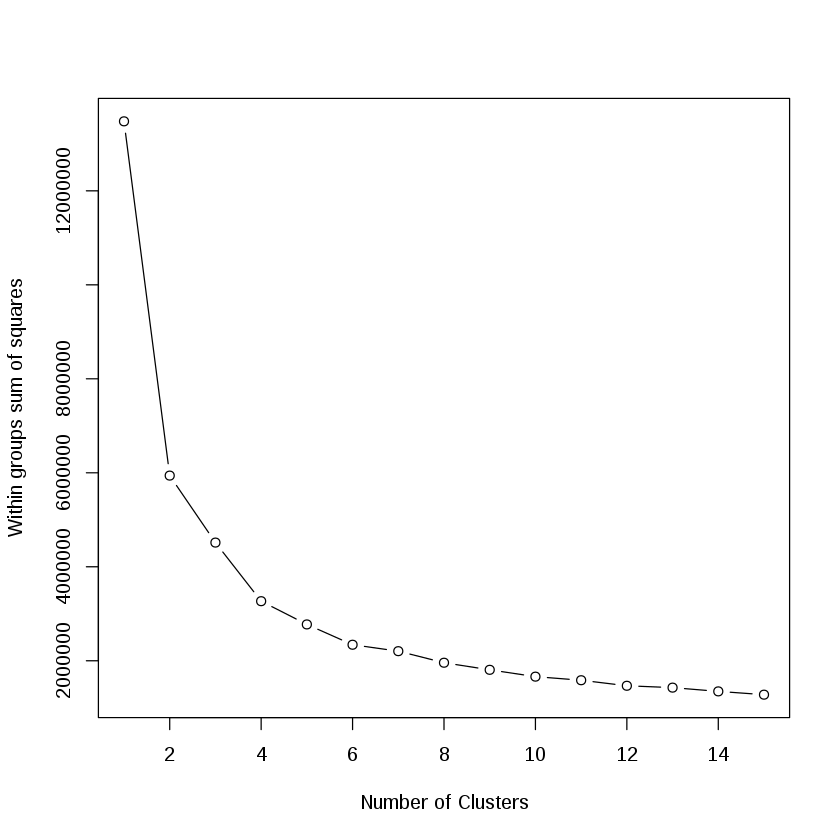

In [64]:
wssplot(combined[,8:10])

In [67]:
# optimal number of clusters = 3-4, taking 3
library(cluster)
km_combined = kmeans(combined[,8:10], 3)

Print cluster membership size and means

In [98]:
km_combined$size
km_combined$centers

[1] 224386 187249 132948

,recency.scaled,frequency.scaled,monetary.scaled
1,3.890225,8.339892,8.325925
2,8.508628,2.924154,3.046889
3,3.979436,4.334793,4.185501


Visualize the three clusters

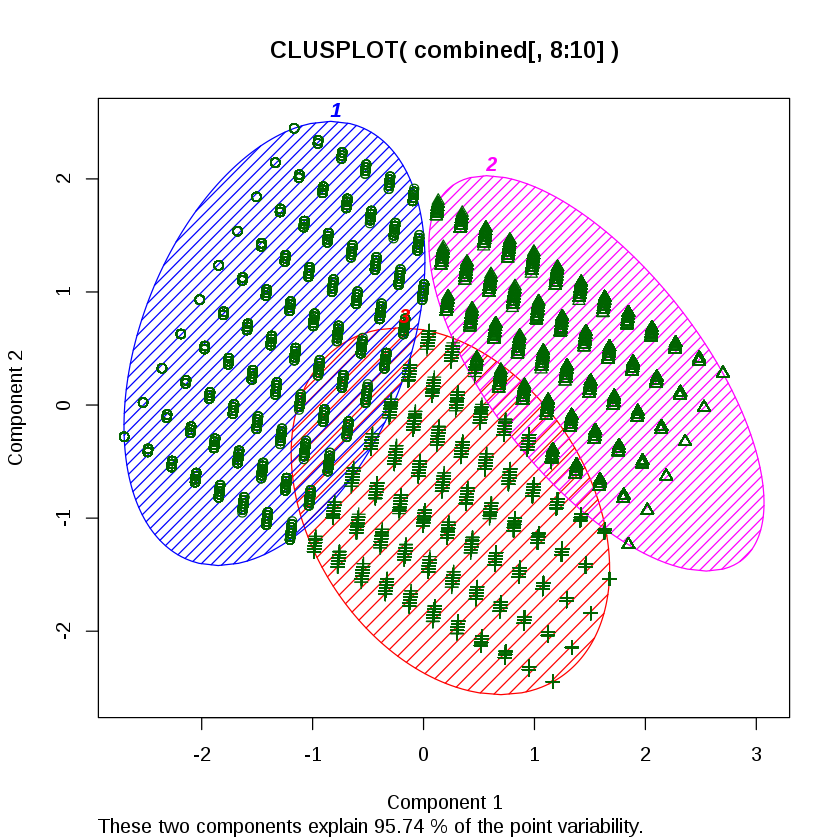

In [69]:
clusplot(combined[,8:10], km_combined$cluster, color=TRUE, shade=TRUE, labels=4, lines=0)

Add cluster assignments to our RFM data

In [70]:
combined <- data.frame(combined, km_combined$cluster)

Split the data into train/test 80/20

In [72]:
set.seed(666) #to get repeatable results

data.train <- sample_frac(combined, 0.8)

train_index <- as.numeric(rownames(data.train))
data.test <- combined[-train_index, ]

**Linear model, pretty poor fit for predicting spend**

In [73]:
# Cluster 1 only

linear_model = lm(spend ~ recency + frequency + monetary, data=data.train[data.train$km_combined.cluster == 1,])
summary(linear_model)


Call:
lm(formula = spend ~ recency + frequency + monetary, data = data.train[data.train$km_combined.cluster == 
    1, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2920.2   -24.6   -17.9     8.9  3765.6 

Coefficients:
             Estimate Std. Error t value            Pr(>|t|)    
(Intercept)  7.183626   0.265897  27.017 <0.0000000000000002 ***
recency      0.020324   0.001909  10.643 <0.0000000000000002 ***
frequency   -0.015120   0.012586  -1.201                0.23    
monetary     0.048669   0.000721  67.502 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 55.15 on 179251 degrees of freedom
Multiple R-squared:  0.08335,	Adjusted R-squared:  0.08334 
F-statistic:  5433 on 3 and 179251 DF,  p-value: < 0.00000000000000022


In [74]:
# All users with transactions

linear_model = lm(tnxs.qty ~ recency + frequency + monetary, data=data.train)
summary(linear_model)


Call:
lm(formula = tnxs.qty ~ recency + frequency + monetary, data = data.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-54.044  -0.331  -0.242   0.277 113.950 

Coefficients:
                Estimate   Std. Error t value            Pr(>|t|)    
(Intercept)  0.185460549  0.002270007  81.700 <0.0000000000000002 ***
recency      0.000003417  0.000010796   0.317               0.752    
frequency    0.015549071  0.000157065  98.998 <0.0000000000000002 ***
monetary    -0.000080577  0.000009088  -8.866 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7321 on 435662 degrees of freedom
Multiple R-squared:  0.09306,	Adjusted R-squared:  0.09305 
F-statistic: 1.49e+04 on 3 and 435662 DF,  p-value: < 0.00000000000000022


**Logistic model. Great fit for all data and separate clusters.**

In [75]:
# Cluster 1 only

log_model = glm(churn ~ recency.scaled + frequency.scaled + monetary.scaled, family=binomial, data=data.train[data.train$km_combined.cluster == 1,])
summary(log_model)
anova(log_model, test="Chisq")


Call:
glm(formula = churn ~ recency.scaled + frequency.scaled + monetary.scaled, 
    family = binomial, data = data.train[data.train$km_combined.cluster == 
        1, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9967  -1.2232   0.7897   0.9951   1.2728  

Coefficients:
                  Estimate Std. Error z value            Pr(>|z|)    
(Intercept)       3.262417   0.041485   78.64 <0.0000000000000002 ***
recency.scaled    0.036762   0.002285   16.09 <0.0000000000000002 ***
frequency.scaled -0.291782   0.004932  -59.16 <0.0000000000000002 ***
monetary.scaled  -0.060280   0.004593  -13.12 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 239851  on 179254  degrees of freedom
Residual deviance: 231105  on 179251  degrees of freedom
AIC: 231113

Number of Fisher Scoring iterations: 4


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,179254,239850.6,NA
recency.scaled,1,1830.5784,179253,238020.0,0.00000000000000000000000000000000000000000000
frequency.scaled,1,6742.2260,179252,231277.8,0.00000000000000000000000000000000000000000000
monetary.scaled,1,172.9665,179251,231104.8,0.00000000000000000000000000000000000000166451


**Test the logistic model for Cluster 1**

In [76]:
fitted.results <- predict(log_model, newdata=data.test[data.test$km_combined.cluster == 1,], type='response')
fitted.results <- ifelse(fitted.results > 0.5, 1, 0)

misClasificError <- mean(fitted.results != data.test[data.test$km_combined.cluster == 1,]$churn)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.636569098845583"


**Cluster 2 test**

In [77]:
log_model = glm(churn ~ recency.scaled + frequency.scaled + monetary.scaled, family=binomial, data=data.train[data.train$km_combined.cluster == 2,])
fitted.results <- predict(log_model, newdata=data.test[data.test$km_combined.cluster == 2,], type='response')
fitted.results <- ifelse(fitted.results > 0.5,1,0)

misClasificError <- mean(fitted.results != data.test[data.test$km_combined.cluster == 2,]$churn)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.816445182724252"


**Cluster 3 test**

In [78]:
log_model = glm(churn ~ recency.scaled + frequency.scaled + monetary.scaled, family=binomial, data=data.train[data.train$km_combined.cluster == 3,])
fitted.results <- predict(log_model, newdata=data.test[data.test$km_combined.cluster == 3,], type='response')
fitted.results <- ifelse(fitted.results > 0.5,1,0)

misClasificError <- mean(fitted.results != data.test[data.test$km_combined.cluster == 3,]$churn)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.802244728289623"


All clusters test

In [79]:
log_model = glm(churn ~ recency.scaled + frequency.scaled + monetary.scaled, family=binomial, data=data.train)
fitted.results <- predict(log_model, newdata=data.test, type='response')
fitted.results <- ifelse(fitted.results > 0.5,1,0)

misClasificError <- mean(fitted.results != data.test$churn)
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.727912079840613"


# Appendix. Methods that had issued and could not be executed.

### Brand-based clustering

Crashed the kernel every time, leaving here as a reference.

In [ ]:
# clustering based on brands

#brand_pref <- full_txns %>%
#    group_by(customer_id) %>%
#    mutate(total.qty = sum(product_quantity))

#brand_pref <- brand_pref %>%
#    group_by(customer_id, brand_id) %>%
#    mutate(brand.qty = sum(product_quantity))

In [ ]:
#brand_pref <- brand_pref %>%
#    group_by(customer_id, brand_id) %>%
#    mutate(brand.pct = brand.qty/total.qty)

In [ ]:
#head(brand_pref1)

In [ ]:
#brand_pref1 <- brand_pref %>%
#    select(-c(product_id, sale_id, transaction_date, product_quantity, product_price, price, division, category, subcategory, fineline, registration_date, total.qty, brand.qty))

In [ ]:
#deduped <- unique(brand_pref1)

In [ ]:
#head(deduped)

In [ ]:
# This causes kernel death :( too many brands

#clus_ready_brand <- deduped %>%
#    group_by(customer_id) %>%
#    spread(brand_id, brand.pct)

### Association rules (using 'arules' package)

Refused to work (killed the kernel every time, even on small sets of transactions). Leaving as a reference.

In [ ]:
# install an older version of arules for R 3.3.3

#library(devtools)
#with_libpaths(new = "UserLibrary", install_version("arules", version = "1.5-0"))

# load association rules
library(arules)

In [ ]:
txns_ar = transactions %>% select(sale_id, product_id)

In [ ]:
txns_ar$product_id = as.factor(txns_ar$product_id)

In [ ]:
txns = txns_ar

In [ ]:
txns = as(txns, 'transactions')

In [ ]:
transactionInfo(txns)[["transactionID"]] = txns_prods$sale_id

In [ ]:
# run apriori :( causes kernel death even with small number of transactions
# could be a compatibility issue, not sure

rules <- apriori(txns, parameter = list(supp = 0.1, conf = 0.2, target = "rules", minlen = 2, maxlen = 3))
rules <- rules[!is.redundant(rules)] # remove redundant rules, i.e. when a more general rule is found

In [ ]:
# check number of rules
length(rules)

# add Chi-square statistic as an interest measure
#quality(rules)$pvalue <- interestMeasure(rules, measure='chi', significance = T, tns)
#quality(rules)$chi    <- interestMeasure(rules, measure='chi', tns)